In [30]:
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
import mutils
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
import radiometric_calib_utils as rcu
import mutils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from math import ceil

# Plot bboxes

In [2]:
with open(r"saved_bboxes\10thSur24Aug_F1_RawImg_IMG_0005_1.txt", 'r') as fp:
    data = json.load(fp)
data

{'F:/surveys_10band/10thSur24Aug/F1/RawImg\\IMG_0005_1.tif': {'turbid_glint': [[22,
    695],
   [102, 826]],
  'water_glint': [[85, 519], [170, 593]],
  'turbid': [[896, 468], [990, 531]],
  'water': [[544, 184], [709, 298]],
  'shore': [[683, 684], [831, 741]]}}

{'F:/surveys_10band/10thSur24Aug/F1/RawImg': {'IMG_0004_1.tif': {'turbid_glint': [[8, 369], [153, 491]], 'water_glint': [[48, 184], [110, 343]], 'turbid': [[834, 343], [930, 406]], 'water': [[979, 88], [1078, 193]], 'shore': [[473, 494], [595, 587]]}, 'IMG_0005_1.tif': {'turbid_glint': [[22, 695], [102, 826]], 'water_glint': [[85, 519], [170, 593]], 'turbid': [[896, 468], [990, 531]], 'water': [[544, 184], [709, 298]], 'shore': [[683, 684], [831, 741]]}}, 'F:/surveys_10band/1stSur6Apr/F1/RawImg': {}, 'F:/surveys_10band/2ndSur28Apr/F1/RawImg': {}}


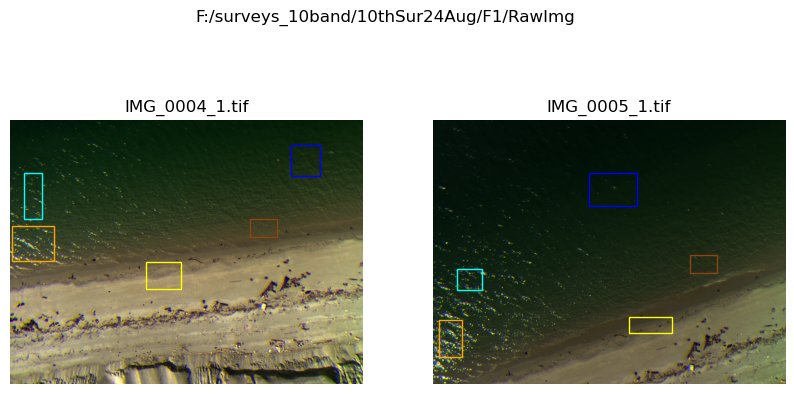

In [39]:
class ExtractSpectral:
    def __init__(self,dir):
        """ 
        :param dir (str): directory of where all the bboxes (.txt) are stored i.e. saved_bboxes/
        """
        self.dir = dir
        # initialise categories
        self.button_names = ['turbid_glint','water_glint','turbid','water','shore']
        # intialise colours
        self.colors = ['orange','cyan','saddlebrown','blue','yellow']
        self.color_mapping = {categories:colors for categories,colors in zip(self.button_names,self.colors)}

    def store_bboxes(self):
        """ 
        get all the bboxes txt files are store the info in a dictionary with keys:
        parent_directory (e.g. 'F:/surveys_10band/10thSur24Aug/F1/RawImg')
            img_names (e.g. 'IMG_0004_1.tif')
        """
        fp_list = [os.path.join(self.dir,fp) for fp in os.listdir(self.dir)]
        store_dict = dict()
        for fp in fp_list:
            with open(fp, 'r') as fp:
                data = json.load(fp)
            basename,file_name = os.path.split(list(data)[0])
            store_dict[basename] = dict()
        
        for fp in fp_list:
            with open(fp, 'r') as fp:
                data = json.load(fp)
            basename,file_name = os.path.split(list(data)[0])
            bboxes = {k: v for d in data.values() for k,v in d.items() if v is not None}
            if bool(bboxes) is True:
                store_dict[basename][file_name] = bboxes
                # store_dict[basename] = {file_name: bboxes}
            
        return store_dict

    def get_warp_matrices(self,current_fp):
        """ 
        from current_fp, import captures and output warp_matrices and cropped_dimensions
        """
        cap = mutils.import_captures(current_fp)
        warp_matrices = cap.get_warp_matrices()
        cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
        return warp_matrices, cropped_dimensions

    def plot_bboxes(self,show_n = 6,figsize=(8,20)):
        """ 
        :param dir (str): directory of where all the bboxes (.txt) are stored i.e. saved_bboxes/
        :param show_n (int): show how many plots. if number of images exceeds show_n, plot only show_n
        """
        def bboxes_to_patches(bboxes):
            if bboxes is not None:
                ((x1,y1),(x2,y2)) = bboxes
                if x1 > x2:
                    x1, x2 = x2, x1
                if y1 > y2:
                    y1, y2 = y2, y1
                h = y1 - y2 # negative height as the origin is on the top left
                w = x2 - x1
                return (x1,y2), w, h
            else:
                return None

        store_dict = self.store_bboxes()

        for flight_fp, img_dict in store_dict.items():
            images_names = list(img_dict)
            n_images = len(images_names)
            if n_images > 0:
                current_fp = os.path.join(flight_fp,images_names[0])
                warp_matrices, cropped_dimensions = self.get_warp_matrices(current_fp)

                if n_images < show_n:
                    fig, axes = plt.subplots(ceil(n_images/2),2,figsize=figsize)
                else:
                    fig, axes = plt.subplots(ceil(show_n/2),2,figsize=figsize)
                    img_dict = {i:img_dict[i] for i in list(images_names)[:show_n]}
                
                for (image_name,bboxes),ax in zip(img_dict.items(),axes.flatten()):
                    current_fp = os.path.join(flight_fp,image_name)
                    cap = mutils.import_captures(current_fp)
                    rgb_image = mutils.aligned_capture_rgb(cap, warp_matrices, cropped_dimensions)
                    ax.imshow(rgb_image)
                    ax.set_title(image_name)
                    ax.axis('off')
                    for categories, b in bboxes.items():
                        coord, w, h = bboxes_to_patches(b)
                        rect = patches.Rectangle(coord, w, h, linewidth=1, edgecolor=self.color_mapping[categories], facecolor='none')
                        patch = ax.add_patch(rect)
                fig.suptitle(flight_fp)
                plt.show()

ES = ExtractSpectral(r"saved_bboxes")
print(ES.store_bboxes())
ES.plot_bboxes(figsize=(10,5))